# Final Project 1: Impacts of Amazon Deforestation on Housed Countries
**Group:** Evelyn Kitagawa  
**Authors:** Colby Alonzo, Morgan Brower, Danicka Sailer, Avani Agaarwal, Eamon Jahouach, Dahalan Vijayakumar

## 📖 Table of Contents
1. [Introduction & Imports](#introduction--imports)  
2. [Population DataFrame](#population-dataframe)  
   - **Deliverable 1[A]** - Population Data Frame  
3. [Population Statistics](#population-statistics)  
   - **Deliverable 3[A]** - Population Statistics Function  
4. [Unit Tests](#unit-tests)  
   - **Deliverable 2[A]** - Unit Tests
5. [Population Pyramids](#population-pyramids)  
   - **Deliverable 4[B]** - Regular Population Pyramids  
   - **Deliverable 4[C]** - Overlayed Population Pyramids  
   - **Deliverable 5[C]** - Animated Population Pyramids
6. [Population Map](#population-pyramids)    
   - **Deliverable 6[C]** - Population Maps  
7. [Other Visualization Tools](#other-visualization-tools)  
   - **Deliverable 7[C]** - Series of different visualizations, depicting gdp, population, emissions, and heatlh trends  
---


In [20]:
%pip install wbdata
%pip install pandas
%pip install iso3166
%pip install cufflinks
%pip install eep153_tools
%pip install plotly
%pip install kagglehub
%pip install os

import wbdata
import pandas as pd
import geopandas as gpd
import math
import iso3166
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import newton
import cufflinks as cf
from matplotlib import animation as ani
import kagglehub
import os
cf.go_offline()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached cufflinks-0.17.3-py3-none-any.whl
  Using cached colorlover-0.3.0-py3-none-any.whl.metadata (421 bytes)
Using cached colorlover-0.3.0-py3-none-any.whl (8.9 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Note: you may need to restart the kernel to use updated packages.


## Country Reference Library

---

Below, we have included a comprehensive reference for all of the country names and codes. Use this list to input the correct country name OR country code for the desired country's demographics. 

In [3]:
iso_countries = pd.DataFrame(
    [(c.name, c.alpha2, c.alpha3, c.numeric, c.apolitical_name) for c in iso3166.countries],
    columns=["Name", "Alpha-2", "Alpha-3", "Numeric", "Political Name"]
)
iso_countries

for country in iso3166.countries:
    print(f"Name: {country.name}, Alpha-3: {country.alpha3}")


Name: Afghanistan, Alpha-3: AFG
Name: Åland Islands, Alpha-3: ALA
Name: Albania, Alpha-3: ALB
Name: Algeria, Alpha-3: DZA
Name: American Samoa, Alpha-3: ASM
Name: Andorra, Alpha-3: AND
Name: Angola, Alpha-3: AGO
Name: Anguilla, Alpha-3: AIA
Name: Antarctica, Alpha-3: ATA
Name: Antigua and Barbuda, Alpha-3: ATG
Name: Argentina, Alpha-3: ARG
Name: Armenia, Alpha-3: ARM
Name: Aruba, Alpha-3: ABW
Name: Australia, Alpha-3: AUS
Name: Austria, Alpha-3: AUT
Name: Azerbaijan, Alpha-3: AZE
Name: Bahamas, Alpha-3: BHS
Name: Bahrain, Alpha-3: BHR
Name: Bangladesh, Alpha-3: BGD
Name: Barbados, Alpha-3: BRB
Name: Belarus, Alpha-3: BLR
Name: Belgium, Alpha-3: BEL
Name: Belize, Alpha-3: BLZ
Name: Benin, Alpha-3: BEN
Name: Bermuda, Alpha-3: BMU
Name: Bhutan, Alpha-3: BTN
Name: Bolivia, Plurinational State of, Alpha-3: BOL
Name: Bonaire, Sint Eustatius and Saba, Alpha-3: BES
Name: Bosnia and Herzegovina, Alpha-3: BIH
Name: Botswana, Alpha-3: BWA
Name: Bouvet Island, Alpha-3: BVT
Name: Brazil, Alpha-3: B

## [A] Population Dataframe

The following function  will return a dataframe containing the requested population. The user can specify to the country, year, and gender of the population that they want. The user can toggle between female, male, or both demographics. This function returns strict age ranges in five year age groups, starting at ages 0-4 and finishing with individuals age 80 and older. These dataframes are indexed by country and year, and should be used to pull world or individual country's population data.

In [64]:
def pop_df(year, sex, country):
    """
    The pop_df is a function that creates a dataframe that contains the specified male or female population demographics,
    indexed by country and year. The user can specify the 'year', 'country', and 'sex' for their requested population. The user 
    can select male, female, or both populations!
    """

    
    def age_helper(age_range):
        """
        This age_helper function creates age ranges that correspond to the format of wbdata's indicators.
        """
        lower, upper = age_range
        start = (lower // 5) * 5
        age_ranges = []
        for age in range(start, upper + 1, 5):
            if age >= 80:
                age_ranges.append("80UP")
                break
            next_age = age + 4
            if next_age >= 80:
                age_ranges.append("80UP")
                break
            age_ranges.append(f"{age:02d}{next_age:02d}")
        return age_ranges

    # Here we call age_helper to generate our age_ranges list.
    age_ranges = age_helper((0, 81))
    
    # Create labels like "00-04", "05-09", ..., with the last group as "80+" that we will eventually use to label our dataframe
    age_labels = [f"{int(age[:2])}-{int(age[2:])}" if age != "80UP" else "80+" 
                  for age in age_ranges]

    # Set country names and codes based on user provided place. 
    if country.lower() == "world":
        name_alpha3 = "WLD"
        name_actual = "World"
    else:
        country_data = iso3166.countries.get(country)
        name_alpha3 = country_data.alpha3
        name_actual = country_data.apolitical_name

        #Creating the male and female indicators based on the created age ranges!
    indicator = 'SP.POP.'
    male_indicators = [f"{indicator}{age}.MA" for age in age_ranges]
    female_indicators = [f"{indicator}{age}.FE" for age in age_ranges]


    def fetch_gender_data(indicators, gender):
        """
            The fetch_gender_data helper function is a used to concatenate individual data frames on each 5 year age range, 
            creating one larger data frame for each gender based on the provided indicators above 
       """ 
        dfs = []
        # Collect each API call's DataFrame in a list.
        for ind in indicators:
            df = wbdata.get_dataframe({ind: gender},
                                        country=name_alpha3,
                                        date=(str(year), str(year)),
                                        parse_dates=True)
            df = df.reset_index()
            df["Country"] = name_actual
            dfs.append(df)
        # Concatenate once after the loop.
        return pd.concat(dfs, axis=0).reset_index(drop=True)

    # Grab male and female population demographics based on the provided indicators and store in a dataframe, respectively
    male_df = fetch_gender_data(male_indicators, "Male")
    female_df = fetch_gender_data(female_indicators, "Female")

    # Assign age labels to each dataframe
    male_df["Ages"] = age_labels
    female_df["Ages"] = age_labels

    # Merge the male and female data frames to create on population data frame
    merged = male_df.merge(female_df, on=["Ages", "date", "Country"],
                           suffixes=("_Male", "_Female"))

    # Rename columns and extract the specified year
    merged = merged.rename(columns={"date": "Year", "Male_Male": "Male", "Female_Female": "Female"})
    merged["Year"] = pd.to_datetime(merged["Year"]).dt.year

    # Returns the correct sex that is specified by the user in parameters
    if (sex.lower() == 'female'):
        final = merged[["Year", "Country", "Ages", "Female"]].set_index(["Country", "Year"])
    elif (sex.lower() == 'male'):
        final = merged[["Year", "Country", "Ages", "Male"]].set_index(["Country", "Year"])
    else:
        final = merged[["Year", "Country", "Ages", "Male", "Female"]].set_index(["Country", "Year"])
    return final

pop_df(1990, 'both', 'Brazil')

Ages       Male     Female
Country Year                             
Brazil  1990    0-4  9151216.0  8854763.0
        1990    5-9  9196771.0  8954043.0
        1990  10-14  8466552.0  8308372.0
        1990  15-19  7560006.0  7459561.0
        1990  20-24  6937745.0  6889244.0
        1990  25-29  6573141.0  6565302.0
        1990  30-34  5733650.0  5755618.0
        1990  35-39  4783833.0  4835453.0
        1990  40-44  3800667.0  3848138.0
        1990  45-49  3089321.0  3037437.0
        1990  50-54  2551819.0  2626940.0
        1990  55-59  2067593.0  2329410.0
        1990  60-64  1670483.0  1950410.0
        1990  65-69  1203242.0  1419071.0
        1990  70-74   769068.0   936899.0
        1990  75-79   456292.0   589271.0
        1990    80+   321235.0   450661.0

## [A] Population Statistics

Below are two population function that intake parameters of year, sex, age_range, and place, and it returns the total population given the specified constraints. Both functions output the final total population for the specified population, while also printing a statement including the specified place, year, sex, and age range. 

The first function, population, totals the exact population figures for the given age range. When an age range is given that is in between  wbdata's age ranges, this function rounds the upper age_range constraint down to give a non-interpolated, exact population. This makes this function best for producing population statistics for exact 5 year age ranges that correspond to the data's given age ranges. 

The second function, interpolated_population, totals the  population for the given age range, population, country and sex, using interpolation to estimate the population between individual ages. This means that when the user includes an age range that is in between an age range, the function calculates the fraction of data that the specified age range is responsible for. This fraction is used in a product with the larger age range population to give us an estimate for the population in that slice of the age range. This allows us to create population statistics for populations in between age ranges, such as male teenagers aged 13-17, without rounding down to use just on age range and giving an inacurrate answer. Use this function to get mre accurate estimates of populations with unique age ranges. 

In [65]:
def population(year, sex, age_range, place):
    # Call pop_df to get the population data
    df = pop_df(year, "both", place)

    # Filter data based on the given sex
    if sex.lower() == "male":
        sex_column = "Male"
    elif sex.lower() == "female":
        sex_column = "Female"
    elif sex.lower() == "both":
        sex_column = None  # Will sum both columns
    else:
        print("Please choose Male, Female, or Both")
        return

     # Function to extract the lower age limit safely
    def extract_lower_age(age_str):
        if "+" in age_str:
            return 80  # Assign 80 as the lower bound for "80+"
        return int(age_str.split("-")[0])
        
    # Filter data for the given age range
    age_groups = df[
        df["Ages"].apply(lambda x: extract_lower_age(x) >= age_range[0] and extract_lower_age(x) <= age_range[1])
    ]

    # Sum the population based on the sex selection
    if sex_column:
        total = age_groups[sex_column].sum()
    else:
        total = age_groups["Male"].sum() + age_groups["Female"].sum()

    print(
        "In the year {}, there were {} {}s aged {} to {} living in {}.".format(
            year, int(total), sex, age_range[0], age_range[1], place
        )
    )

    return int(total)

population(2000, 'male', (13, 17), 'brazil')

In the year 2000, there were 9080529 males aged 13 to 17 living in brazil.


9080529

In [90]:
def interpolated_population(year, sex, age_range, place):
    # Call pop_df to get the population data
    df = pop_df(year, "both", place)

    # Determine which columns to use based on the sex argument.
    if sex.lower() == "male":
        sex_column = "Male"
    elif sex.lower() == "female":
        sex_column = "Female"
    elif sex.lower() == "both":
        sex_column = None
    else:
        print("Please choose Male, Female, or Both")
        return

    # Convert the provided age_range (assumed inclusive, e.g. 13 to 17) 
    # to a half-open interval [lower, upper) for interpolation.
    target_lower = age_range[0]
    target_upper = age_range[1] + 1  # e.g., (13, 17) becomes [13, 18)

    # Helper function to parse the age group label from the DataFrame.
    # For example, "10-14" is converted to (10, 15), and "80+" is assumed to span 80 to 100.
    def parse_age_group(label):
        if '+' in label:
            # You can adjust the upper bound (here assumed as 100) based on your data or assumptions.
            return (80, 100)
        else:
            lower_str, upper_str = label.split('-')
            lower = int(lower_str)
            # Add 1 to convert to a half-open interval, e.g. 10-14 becomes [10,15)
            upper = int(upper_str) + 1
            return (lower, upper)

    total = 0.0
    # Iterate over each row of the DataFrame, computing the contribution of each age group.
    for _, row in df.iterrows():
        group_lower, group_upper = parse_age_group(row["Ages"])

        # Calculate the overlap between the group's interval and the target interval.
        overlap_lower = max(group_lower, target_lower)
        overlap_upper = min(group_upper, target_upper)

        if overlap_lower < overlap_upper:  # There is some overlap.
            # Calculate the fraction of this age group's span that falls within the target range.
            fraction = (overlap_upper - overlap_lower) / (group_upper - group_lower)
            # Get the appropriate population count based on the sex selection.
            if sex_column:
                pop_value = row[sex_column]
            else:
                pop_value = row["Male"] + row["Female"]
            total += pop_value * fraction

    print(
        "In the year {}, there were {} {}s aged {} to {} living in {}.".format(
            year, int(total), sex, age_range[0], age_range[1], place
        )
    )
    return int(total)


interpolated_population(2000, 'male', (13, 17), 'brazil')

In the year 2000, there were 9047036 males aged 13 to 17 living in brazil.


9047036

## [A] Unit Tests

Below are Unit tests made to test population function. The tests are made up of a series of basic inputs, as well as many to test edge cases.

In [72]:
#Tests for population!

# Test 1: Standard input - Brazil, male, ages 20-60 in 2000
assert population(2000, 'male', (20, 60), 'brazil') == 47111262

# Test 2: Ecuador, female population, ages 0-4 in 2010
assert population(2010, 'female', (0, 4), 'ecuador') == 784333

# Test 3: Colombia, unspecified sex, ages 80+ in 1995
assert population(1995, 'both', (80, 100), 'colombia') == 252931

# Test 4: Venezuela, male population, single age group (25-29) in 2020
assert population(2020, 'male', (25, 29), 'VEN') == 972737

# Test 5: World population, female, ages 10-14 in 2015
assert population(2015, 'female', (10, 14), 'world') == 303263011  # Placeholder value for global data

# Test 6: Edge case - Minimum age range (0-0), unspecified sex, Ecuador, 2005
assert population(2005, 'unspecified', (0, 4), 'ecuador') == print('Please choose Male, Female, or Both')

# Test 7: Edge case - Maximum age range (0-100), male, Colombia, 1990
assert population(1990, 'male', (0, 100), 'colombia') == 16197631 

# Test 8: Invalid sex input ("other"), Venezuela, ages 20-24 in 2010
assert population(2010, 'other', (20, 24), 'Venezuela, Bolivarian Republic of') == print('Please choose Male, Female, or Both')

# Test 9: Case insensitivity - BRAZIL (uppercase), FeMale (mixed case), ages 30-34 in 2015
assert population(2015, 'FeMale', (30, 34), 'BRAZIL') == 8612358  # Placeholder value

# Test 10: Single country code input - using ISO code for Colombia ('COL'), male, ages 15-19 in 2000
assert population(2000, 'male', (15, 19), 'COL') == 1966993





#TESTS FOR interpolated_population!

# Test 1: Standard input - Brazil, male, ages 20-60 in 2000
assert interpolated_population(2000, 'male', (20, 60), 'brazil') == 45389194

# Test 2: Ecuador, female population, ages 0-4 in 2010
assert interpolated_population(2010, 'female', (0, 4), 'ecuador') == 784333

# Test 3: Colombia, unspecified sex (both), ages 80+ in 1995
assert interpolated_population(1995, 'both', (80, 100), 'colombia') == 252931

# Test 4: Venezuela, male population, single age group (25-29) in 2020
assert interpolated_population(2020, 'male', (25, 29), 'VEN') == 972737

# Test 5: World population, female, ages 10-14 in 2015
assert interpolated_population(2015, 'female', (10, 14), 'world') == 303263011  # Placeholder value for global data

# Test 6: Edge case - Minimum age range (0-0), unspecified sex, Ecuador, 2005
assert interpolated_population(2005, 'unspecified', (0, 4), 'ecuador') == print('Please choose Male, Female, or Both')

# Test 7: Edge case - Maximum age range (0-100), male, Colombia, 1990
assert interpolated_population(1990, 'male', (0, 100), 'colombia') == 16197631 

# Test 8: Invalid sex input ("other"), Venezuela, ages 20-24 in 2010
assert interpolated_population(2010, 'other', (20, 24), 'Venezuela, Bolivarian Republic of') == print('Please choose Male, Female, or Both')

# Test 9: Case insensitivity - BRAZIL (uppercase), FeMale (mixed case), ages 30-34 in 2015
assert interpolated_population(2015, 'FeMale', (30, 34), 'BRAZIL') == 8612358  # Placeholder value

# Test 10: Single country code input - using ISO code for Colombia ('COL'), male, ages 15-19 in 2000
assert interpolated_population(2000, 'male', (15, 19), 'COL') == 1966993


In the year 2000, there were 47111262 males aged 20 to 60 living in brazil.
In the year 2010, there were 784333 females aged 0 to 4 living in ecuador.
In the year 1995, there were 252931 boths aged 80 to 100 living in colombia.
In the year 2020, there were 972737 males aged 25 to 29 living in VEN.
In the year 2015, there were 303263011 females aged 10 to 14 living in world.
Please choose Male, Female, or Both
Please choose Male, Female, or Both
In the year 1990, there were 16197631 males aged 0 to 100 living in colombia.
Please choose Male, Female, or Both
Please choose Male, Female, or Both
In the year 2015, there were 8612358 FeMales aged 30 to 34 living in BRAZIL.
In the year 2000, there were 1966993 males aged 15 to 19 living in COL.
In the year 2000, there were 45389194 males aged 20 to 60 living in brazil.
In the year 2010, there were 784333 females aged 0 to 4 living in ecuador.
In the year 1995, there were 252931 boths aged 80 to 100 living in colombia.
In the year 2020, there 

## [B] Population Pyramids

In [73]:
def population_pyramid(year, country):

    data = pop_df(year,'both', country)
    y_age = data['Ages']
    x_M = data['Male']
    x_F = data['Female']*-1

    new_year = str(year)
    #creating instance of the figure
    fig = go.Figure()

    #Adding male data
    fig.add_trace(go.Bar(y = y_age, x = x_M, name = 'Male', orientation = 'h'))

    #Adding Female data
    fig.add_trace(go.Bar(y = y_age, x = x_F, name = 'Female', orientation = 'h'))

    #Updating layout of the figure
    fig.update_layout(title = country.capitalize() +' Population Pyramid (' + new_year + ')',
                      title_font_size = 22, barmode = 'relative',
                      bargap = 0.0, bargroupgap = 0,
                      xaxis = dict(title = 'Population in Millions',
                               title_font_size = 14
                              )
                 )
    fig.show()

In [74]:
population_pyramid(2023, "Brazil")

In [75]:
population_pyramid(2023, "Ecuador")

In [76]:
population_pyramid(2023, "bol")

In [77]:
population_pyramid(2023, "Peru")

## [C] Overlayed Population Pyramid

In [78]:
def overlay_population_pyramid(years, country, layout=None):
    """
    Plots an overlaid population pyramid for multiple years by fetching population data.

    Parameters:
    - years: List of years to include in the population pyramid.
    - country: The country for which to fetch population data.
    - layout: Custom Plotly layout configuration (optional).

    Returns:
    - None (displays the plot).
    """

    bins = []

    for year in years:
        # Fetch the population data for the specified year
        df = pop_df(year, 'both', country)

        # Generate the age ranges for the y-axis
        age_ranges = df['Ages'].unique()

        # Create the bars for males
        bins.append(
            go.Bar(
                x=df['Male'],
                y=age_ranges,
                orientation="h",
                name=f"Men {year}",
                hoverinfo="skip",
                opacity=0.5
            )
        )

        # Create the bars for females
        bins.append(
            go.Bar(
                x=-df['Female'],
                y=age_ranges,
                orientation="h",
                name=f"Women {year}",
                hoverinfo="skip",
                opacity=0.5
            )
        )

    # Set default layout if none is provided
    if layout is None:
        layout = go.Layout(
            title=f"Population Pyramid for {country} Over {years[0]}-{years[-1]}",
            barmode="overlay",
            xaxis=dict(title="Population"),
            yaxis=dict(title="Age Groups"),
            bargap=0.1,
        )

    # Plot the population pyramid
    py.iplot(dict(data=bins, layout=layout))

In [79]:
overlay_population_pyramid([1990, 2023], 'Brazil')

In [80]:
overlay_population_pyramid([1990, 2023], 'Ecuador')

In [81]:
overlay_population_pyramid([1990, 2023], 'Bol')

In [82]:
overlay_population_pyramid([1990, 2023], 'Peru')

## [C] Animated Population Pyramid

In [83]:
def animated_population_pyramid(years, country):
    # Initialize a list to hold frames
    frames = []
    #Turn years into a ranged list
    range_years = range(years[0], years[-1]+1)
    # Loop through each year in the specified range
    for year in range_years:
        # Fetch population data for the current year
        data = pop_df(year, 'both', country)
        
        # Prepare data for the pyramid
        y_age = data['Ages']
        x_male = data['Male']
        x_female = -data['Female']  # Negative for left side of pyramid
    
        # Create a bar trace for males
        male_trace = go.Bar(
            y=y_age,
            x=x_male,
            name='Male',
            orientation='h',
            marker=dict(color='blue'),
            opacity=0.6  # Set opacity for male bars
        )

        # Create a bar trace for females
        female_trace = go.Bar(
            y=y_age,
            x=x_female,
            name='Female',
            orientation='h',
            marker=dict(color='red'),
            opacity=0.6  # Set opacity for female bars
        )

        # Append the frame for the current year
        frames.append(go.Frame(data=[male_trace, female_trace], name=str(year)))

    # Determine the maximum population for setting x-axis limits
    max_population = max(data['Male'].max(), data['Female'].max())

    # Create the initial figure layout
    fig = go.Figure(
        data=frames[0].data,
        layout=go.Layout(
            title=f'Animated Population Pyramid of {country.capitalize()} ({years[0]}-{years[-1]})',
            barmode='overlay',
            bargap=0.1,
            xaxis=dict(
                title='Population',
                tickmode='auto',
                nticks=8,
                range=[-max_population * 1.1, max_population * 1.1]
            ),
            yaxis=dict(
                title='Age Group',
                categoryorder='array',
                categoryarray=y_age
            ),
            updatemenus=[{
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
                        'label': 'Play',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': 'Pause',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'showactive': False,
                'type': 'buttons',
                'x': 0.1,
                'xanchor': 'right',
                'y': 0,
                'yanchor': 'top'
            }]
        ),
        frames=frames
    )

    # Update layout for sliders
    fig.update_layout(
        sliders=[{
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 20},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            },
            'transition': {'duration': 300, 'easing': 'cubic-in-out'},
            'pad': {'b': 10, 't': 50},
            'len': 0.9,
            'x': 0.1,
            'y': 0,
            'steps': [{
                'args': [[str(year)], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                'label': str(year),
                'method': 'animate'
            } for year in range_years]
        }]
    )

    # Show the figure
    fig.show()

In [85]:
animated_population_pyramid([1990,2023], 'Brazil')

## [C] Population Map

In [32]:
# Load the dataset
file_path = "south-america_652.geojson"
southamerica = gpd.read_file(file_path)

df = southamerica
filtered_df = df[df['name'].isin(["Brazil", "Peru", "Ecuador", "Bolivia"])]
filtered_df = filtered_df.rename(columns={"name": "Country"})

#Loading Dataset
path = kagglehub.dataset_download("nelgiriyewithana/countries-of-the-world-2023")

files = os.listdir(path)

file_name = [f for f in files if f.endswith(".csv")][0]
file_path = os.path.join(path, file_name)

# Looking at dataset
population = pd.read_csv(file_path)
# Merging two datasets
merged_df = filtered_df.merge(population, on = "Country")
merged_df

,Country,cartodb_id,created_at,updated_at,geometry,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Brazil,33,2013-11-27 20:16:22+01:00,2013-11-27 20:16:23+01:00,"MULTIPOLYGON (((-48.48589 -27.76699, -48.55459...",25,BR,33.90%,"8,515,770","730,000",...,28.30%,2.15,"212,559,417",63.90%,14.20%,65.10%,12.08%,"183,241,641",-14.235004,-51.925280
1,Bolivia,32,2013-11-27 20:16:22+01:00,2013-11-27 20:16:23+01:00,"POLYGON ((-58.15977 -20.16465, -58.13994 -19.9...",11,BO,34.80%,"1,098,581","71,000",...,25.90%,1.59,"11,513,100",71.80%,17.00%,83.70%,3.50%,"8,033,035",-16.290154,-63.588653
2,Ecuador,64,2013-11-27 20:16:22+01:00,2013-11-27 20:16:23+01:00,"MULTIPOLYGON (((-80.13159 -2.97314, -80.15068 ...",71,EC,22.20%,"283,561","41,000",...,43.70%,2.04,"17,373,662",68.00%,NaN,34.40%,3.97%,"11,116,711",-1.831239,-78.183406
3,Peru,171,2013-11-27 20:16:22+01:00,2013-11-27 20:16:23+01:00,"POLYGON ((-69.96592 -4.23594, -69.97202 -4.301...",26,PE,18.50%,"1,285,216","158,000",...,30.90%,1.27,"32,510,453",77.60%,14.30%,36.80%,3.31%,"25,390,339",-9.189967,-75.015152


In [33]:
# Load the dataset
file_path = "population.csv"
southamericapast = pd.read_csv(file_path)

# Renaming Column 
southamericapast = southamericapast.rename(columns={"Country Name": "Country"})

# Filter for Peru, Bolivia, Brazil, and Ecuador for Year 1960
filtered_southamerica1960 = southamericapast[
    (southamericapast["Country"].isin(["Peru", "Bolivia", "Brazil", "Ecuador"])) &
    (southamericapast["Year"] == 1960)]

# Input Land Size for each country to find density
filtered_southamerica1960["Land Size (km²)"] = [1098581, 8514215, 283561, 1285220]

#Create a new column for density by dividing population by land size
filtered_southamerica1960["Density (P/Km^2)"] = filtered_southamerica1960["Value"] / filtered_southamerica1960["Land Size (km²)"]
filtered_southamerica1960

,Country,Country Code,Year,Value,Land Size (km²),Density (P/Km^2)
1792,Bolivia,BOL,1960,3702323.0,1098581,3.370096
1856,Brazil,BRA,1960,72388126.0,8514215,8.502032
4224,Ecuador,ECU,1960,4590891.0,283561,16.190135
11840,Peru,PER,1960,10174127.0,1285220,7.916253


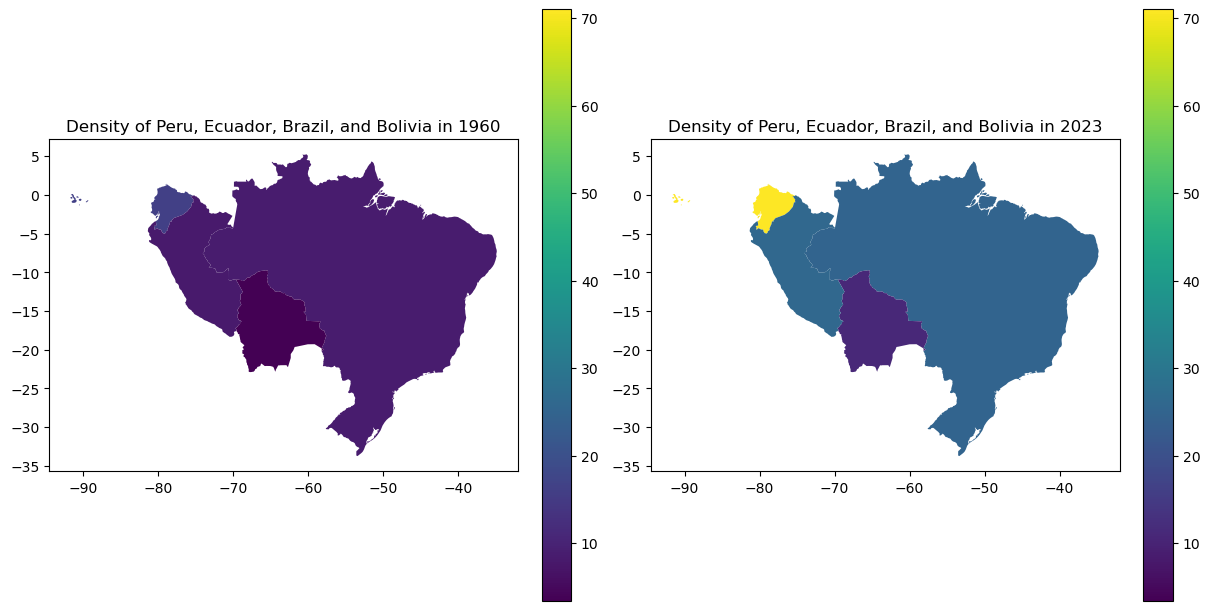

In [40]:
# Population Density in 1960
merged_df_1960 = filtered_df.merge(filtered_southamerica1960, on="Country")

# Population Density in 2023
merged_df = filtered_df.merge(population, on="Country")

# Make sure both columns are numeric (in case they were read as strings).
merged_df_1960["Density (P/Km^2)"] = merged_df_1960["Density (P/Km^2)"].astype(float)
merged_df["Density\n(P/Km2)"]      = merged_df["Density\n(P/Km2)"].astype(float)

# Determine the overall min and max across both years
min_val = min(merged_df_1960["Density (P/Km^2)"].min(),
              merged_df["Density\n(P/Km2)"].min())
max_val = max(merged_df_1960["Density (P/Km^2)"].max(),
              merged_df["Density\n(P/Km2)"].max())

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

# Plot 1960 data
merged_df_1960.plot(
    column="Density (P/Km^2)",
    ax=axes[0],
    cmap="viridis",          # or any continuous colormap
    legend=True,
    vmin=min_val,            # force both plots to use the same scale
    vmax=max_val
)
axes[0].set_title("Density of Peru, Ecuador, Brazil, and Bolivia in 1960")

# Plot 2023 data
merged_df.plot(
    column="Density\n(P/Km2)",
    ax=axes[1],
    cmap="viridis",
    legend=True,
    vmin=min_val,            # same scale
    vmax=max_val
)
axes[1].set_title("Density of Peru, Ecuador, Brazil, and Bolivia in 2023")

plt.show()

## [C] Visualization Tools

### Population Growth Overtime in Peru, Ecuador, Brazil and Bolivia

In [42]:
filtered_southamerica_Peru = southamericapast[southamericapast["Country"] == "Peru"]
filtered_southamerica_Brazil = southamericapast[southamericapast["Country"] == "Brazil"]
filtered_southamerica_Ecuador = southamericapast[southamericapast["Country"] == "Ecuador"]
filtered_southamerica_Bolivia = southamericapast[southamericapast["Country"] == "Bolivia"]

world_labels = {"SP.POP.TOTL":"World Population"}

world = wbdata.get_dataframe(world_labels, country="WLD",parse_dates=True)

total_labels = {"SP.RUR.TOTL":"Rural Population"}

Brazil_rural_population = wbdata.get_dataframe(total_labels, country="BRA",parse_dates=True)

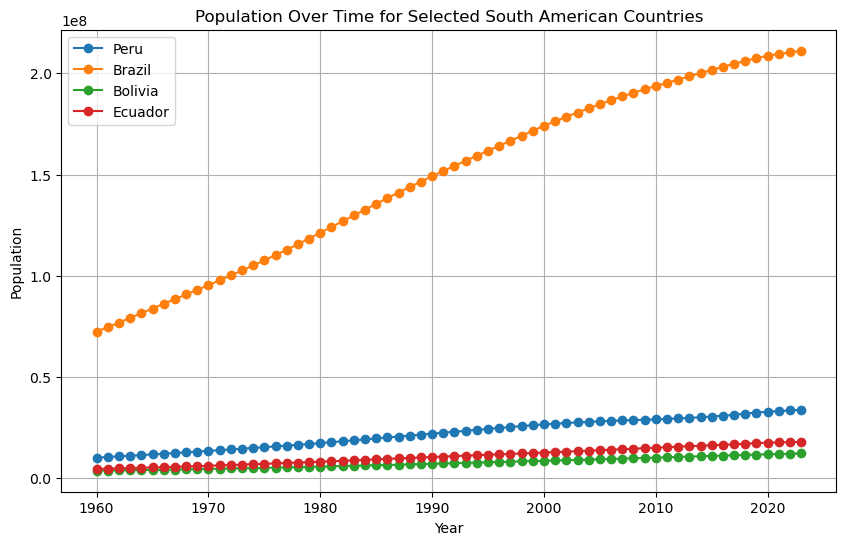

In [43]:
# Ensure Year column is numeric for all dataframes
for df in [filtered_southamerica_Peru, filtered_southamerica_Brazil, 
           filtered_southamerica_Bolivia, filtered_southamerica_Ecuador]:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')  # Convert Year column to numeric, coerce errors
    df.dropna(subset=['Year', 'Value'], inplace=True)  # Remove rows with NaN values

# Plot each country's population on the same figure
plt.figure(figsize=(10, 6))  # Set figure size

# Define dataset dictionary for cleaner plotting
datasets = {
    "Peru": filtered_southamerica_Peru,
    "Brazil": filtered_southamerica_Brazil,
    "Bolivia": filtered_southamerica_Bolivia,
    "Ecuador": filtered_southamerica_Ecuador
}

# Iterate over datasets and plot
for country, df in datasets.items():
    plt.plot(df['Year'], df['Value'], marker='o', linestyle='-', label=country)

# Add labels, title, and grid
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population Over Time for Selected South American Countries')
plt.grid(True)
plt.legend()  # Show legend to differentiate countries

# Display the plot
plt.show()

### Food Production vs. Population in Brazil

In [44]:
pd.options.plotting.backend = 'plotly'

# Play with these constants
## for exponential
P0 = 1
r = 0.0051  # Rate of population growth

## for line
F0 = 10
m = 100

def food_production(t,m=m):
    return F0+m*t

def population(t,r=r):
    return P0*np.exp(r*t)

def choose_xaxis(r,m,x0=10):
    """
    Find a range of x so that curves intersect
    """
    tstar = -1
    try:
        while tstar <= 0:
            tstar = newton(lambda t: food_production(t,m) - population(t,r),x0,maxiter=1000)
            x0 = x0*10
        return np.linspace(0,tstar*1.1,100)
    except RuntimeError: # Failed to find root
        return np.linspace(0,1000,100)

T = choose_xaxis(r,m)

df = pd.DataFrame({'Time': T,
                   'Food production':[food_production(t) for t in T],
                   'Brazil':[population(t) for t in T]}).set_index('Time')
df.plot()

### Change in Forest Land % in Bolivia, Brazil, Ecuador, and Peru

In [47]:
vars = {"AG.LND.FRST.ZS":"Deforestation"}

use=["BRA","ECU","PER","BOL"]

deforestation = wbdata.get_dataframe(vars,country=use,parse_dates=True).squeeze().unstack('country')
deforestation = deforestation.loc["1990":]

plot = deforestation.plot(title="Country's Percentage of Forest Area over the Years", labels={"index": "Year", "value": "Country's Forest (%)"})
plot.show()

## Forest Area vs. GDP

### Forest area (sq. km) vs GDP in Brazil Over Time

In [49]:
# Define indicators for Forest area and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest area (sq. km) for brazil",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "BRA"  # Brazil's country code

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add Terrestrial Protected Areas trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest area (sq. km) for brazil"], 
                         mode="lines", name="Forest Area", 
                         yaxis="y1"))

# Add GDP trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Forest area (sq. km) vs GDP in Brazil Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Forest area (sq. km) for brazil", side="left", showgrid=False),
    yaxis2=dict(title="GDP (current US$)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### Forest area (sq. km) vs GDP in Ecuador Over Time

In [50]:
# Define indicators for Terrestrial Protected Areas and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest area (sq. km) for Ecuador",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "ECU"  # Brazil's country code

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add Terrestrial Protected Areas trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest area (sq. km) for Ecuador"], 
                         mode="lines", name="Forest Area", 
                         yaxis="y1"))

# Add GDP trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Forest area (sq. km) vs GDP in Ecuador Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Forest area (sq. km) for Ecuador", side="left", showgrid=False),
    yaxis2=dict(title="GDP (current US$)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### Forest area (sq. km) vs GDP in Peru Over Time

In [51]:
# Define indicators for Terrestrial Protected Areas and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest area (sq. km) for Peru",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "PER"  # Brazil's country code

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add Terrestrial Protected Areas trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest area (sq. km) for Peru"], 
                         mode="lines", name="Forest Area", 
                         yaxis="y1"))

# Add GDP trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Forest area (sq. km) vs GDP in Peru Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Forest area (sq. km) for Peru", side="left", showgrid=False),
    yaxis2=dict(title="GDP (current US$)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### Forest area (sq. km) vs GDP in Bolivia Over Time

In [ ]:
indicators = {
    "AG.LND.FRST.K2": "Forest area (sq. km) for Bolivia",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "BOL"  # Brazil's country code

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=data.index, y=data["Forest area (sq. km) for Bolivia"], 
                         mode="lines", name="Forest Area", 
                         yaxis="y1"))

# Add GDP trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Forest area (sq. km) vs GDP in Bolivia Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Forest area (sq. km) for Bolivia", side="left", showgrid=False),
    yaxis2=dict(title="GDP (current US$)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()


## Agriculture CO2 Emissions vs Forest Area

### Agricultural CO2 Emissions vs Forest Area in Brazil Over Time

In [54]:
# Define indicators for Agricultural CO2 Emissions and Forest Area
indicators = {
    "EN.GHG.CO2.AG.MT.CE.AR5": "CO2 Emissions from Agriculture (Mt CO2e)",
    "AG.LND.FRST.K2": "Forest Area (sq. km)"
}

# Define country
country = "BRA"  # Brazil's country code

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add CO2 Emissions trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["CO2 Emissions from Agriculture (Mt CO2e)"], 
                         mode="lines", name="CO2 Emissions (Mt CO2e)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Agricultural CO2 Emissions vs Forest Area in Brazil Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="CO2 Emissions from Agriculture (Mt CO2e)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### Agricultural CO2 Emissions vs Forest Area in Ecuador Over Time

In [56]:
# Define indicators for Agricultural CO2 Emissions and Forest Area
indicators = {
    "EN.GHG.CO2.AG.MT.CE.AR5": "CO2 Emissions from Agriculture (Mt CO2e)",
    "AG.LND.FRST.K2": "Forest Area (sq. km)"
}

# Define country
country = "ECU"  

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add CO2 Emissions trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["CO2 Emissions from Agriculture (Mt CO2e)"], 
                         mode="lines", name="CO2 Emissions (Mt CO2e)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Agricultural CO2 Emissions vs Forest Area in Ecuador Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="CO2 Emissions from Agriculture (Mt CO2e)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### Agricultural CO2 Emissions vs Forest Area in Peru Over Time

In [58]:
# Define indicators for Agricultural CO2 Emissions and Forest Area
indicators = {
    "EN.GHG.CO2.AG.MT.CE.AR5": "CO2 Emissions from Agriculture (Mt CO2e)",
    "AG.LND.FRST.K2": "Forest Area (sq. km)"
}

# Define country
country = "PER" 

# Fetch data from World Bank API
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add CO2 Emissions trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["CO2 Emissions from Agriculture (Mt CO2e)"], 
                         mode="lines", name="CO2 Emissions (Mt CO2e)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="Agricultural CO2 Emissions vs Forest Area in Peru Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="CO2 Emissions from Agriculture (Mt CO2e)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()


## GDP vs Forest Area

### GDP and Forest Area in Brazil Over Time

In [59]:
# Define indicators for forest area and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest Area (sq. km)",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "BRA"  # Brazil's country code

# Fetch data from World Bank API (without convert_date)
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add GDP trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="GDP and Forest Area in Brazil Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="GDP (USD)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### GDP and Forest Area in Peru Over Time

In [60]:
# Define indicators for forest area and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest Area (sq. km)",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "PER"  # Peru's country code

# Fetch data from World Bank API (without convert_date)
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add GDP trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="GDP and Forest Area in Peru Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="GDP (USD)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### GDP and Forest Area in Ecuador Over Time

In [61]:
# Define indicators for forest area and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest Area (sq. km)",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "ECU"  # Ecuador's country code

# Fetch data from World Bank API (without convert_date)
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add GDP trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="GDP and Forest Area in Ecuador Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="GDP (USD)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()

### GDP and Forest Area in Bolivia Over Time

In [62]:
# Define indicators for forest area and GDP
indicators = {
    "AG.LND.FRST.K2": "Forest Area (sq. km)",
    "NY.GDP.MKTP.CD": "GDP (current US$)"
}

# Define country
country = "BOL"  # Bolivia's country code

# Fetch data from World Bank API (without convert_date)
data = wbdata.get_dataframe(indicators, country=country)

# Convert index (years) to datetime format
data.index = pd.to_datetime(data.index.astype(str) + "-01-01")

# Drop missing values
data.dropna(inplace=True)

# Create figure
fig = go.Figure()

# Add GDP trace (left y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["GDP (current US$)"], 
                         mode="lines", name="GDP (USD)", 
                         yaxis="y1"))

# Add Forest Area trace (right y-axis)
fig.add_trace(go.Scatter(x=data.index, y=data["Forest Area (sq. km)"], 
                         mode="lines", name="Forest Area (sq. km)", 
                         yaxis="y2"))

# Update layout for dual axes
fig.update_layout(
    title="GDP and Forest Area in Bolivia Over Time",
    xaxis=dict(title="Year"),
    yaxis=dict(title="GDP (USD)", side="left", showgrid=False),
    yaxis2=dict(title="Forest Area (sq. km)", side="right", overlaying="y", showgrid=False),
    legend=dict(x=0.1, y=1.1)
)

# Show plot
fig.show()